In [1]:
import pandas as pd
from datetime import datetime
from sqlalchemy import create_engine
from sqlalchemy import text

db_username = 'tupo'
db_password = 'npg_mbhaH6B3jdzy'
db_host = 'ep-bold-king-a52tlxdq-pooler.us-east-2.aws.neon.tech'
db_port = '5432'  # 默认为5432
db_name = 'day_ahead_spot'

conn = create_engine(f'postgresql+psycopg2://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}')
query = "SELECT * FROM day_ahead_marginal_data;"
df = pd.read_sql_query(query, conn)

In [2]:
from datetime import timedelta
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43872 entries, 0 to 43871
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         43872 non-null  object 
 1   time_slot                    43872 non-null  object 
 2   bidding_space                43872 non-null  float64
 3   renewable_load               43872 non-null  float64
 4   provincial_dispatch_load     43872 non-null  float64
 5   interconnection_plan         43872 non-null  float64
 6   day_ahead_online_capacity    43872 non-null  float64
 7   day_ahead_load_rate_percent  43872 non-null  float64
 8   day_ahead_clearing_price     43872 non-null  float64
dtypes: float64(7), object(2)
memory usage: 3.0+ MB


In [3]:
def estimate_clearing_price(df, query_date, lookback_days=5):
    # 确保 'date' 列为 datetime 类型
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    # 计算起始日期
    start_date = query_date - timedelta(days=lookback_days)

    # 筛选日期在 start_date 和 query_date 之间的行
    mask = (df['date'] >= start_date) & (df['date'] <= query_date)
    filtered_df = df.loc[mask]

    return filtered_df

In [4]:

# 确保 'date' 列为 datetime 类型
df['date'] = pd.to_datetime(df['date'])

# 定义查询日期和回溯天数
query_date = pd.Timestamp('2025-03-31')
lookback_days = 30

# 调用函数
filtered_df = estimate_clearing_price(df, query_date, lookback_days)
result_df = filtered_df[['date', 'time_slot', 'day_ahead_clearing_price']]
# 查看结果
print(result_df)


           date time_slot  day_ahead_clearing_price
5664 2025-03-01  00:15:00                     315.0
5665 2025-03-01  00:30:00                     315.0
5666 2025-03-01  00:45:00                     318.0
5667 2025-03-01  01:00:00                     315.0
5668 2025-03-01  01:15:00                     315.0
...         ...       ...                       ...
8635 2025-03-31  23:00:00                     282.0
8636 2025-03-31  23:15:00                     280.0
8637 2025-03-31  23:30:00                     266.0
8638 2025-03-31  23:45:00                     260.0
8639 2025-03-31  00:00:00                     260.0

[2976 rows x 3 columns]


In [5]:
result_df.describe()

,date,day_ahead_clearing_price
count,2976,2976.000000
mean,2025-03-16 00:00:00,270.729862
min,2025-03-01 00:00:00,0.000000
25%,2025-03-08 00:00:00,22.560000
50%,2025-03-16 00:00:00,280.000000
75%,2025-03-24 00:00:00,320.000000
max,2025-03-31 00:00:00,1261.000000
std,NaN,247.394660


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_price_boxplot(df):
    # 设置Seaborn风格
    sns.set_style("whitegrid")
    
    # 设置图形大小和DPI以提高清晰度
    plt.figure(figsize=(16, 9), dpi=100)
    
    # 创建箱型图，使用默认颜色
    ax = sns.boxplot(x='time_slot', y='day_ahead_clearing_price', data=df, 
                     width=0.6, linewidth=1.5)
    
    # 添加标题和轴标签，使用更好的字体和大小
    plt.title('Day-Ahead Clearing Prices Distribution by Time Slot', fontsize=18, pad=20)
    plt.xlabel('Time Slot', fontsize=14, labelpad=10)
    plt.ylabel('Clearing Price ($/MWh)', fontsize=14, labelpad=10)
    
    # 旋转X轴标签并对齐
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    
    # 添加网格线以便更好地对比价格
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # 添加均值线（可选）
    means = df.groupby('time_slot')['day_ahead_clearing_price'].mean().values
    plt.plot(range(len(means)), means, 'ro-', linewidth=2, markersize=6, 
             label='Mean Price')
    plt.legend(fontsize=12)
    
    # 紧凑布局并显示
    plt.figtext(0.01, 0.01,
            f"Data period: {df['date'].min().strftime('%Y-%m-%d')} - {df['date'].max().strftime('%Y-%m-%d')}",
            fontsize=10, style='italic')

    plt.tight_layout()
    plt.savefig('clearing_price_by_timeslot_boxplot.png', bbox_inches='tight')
    plt.show()

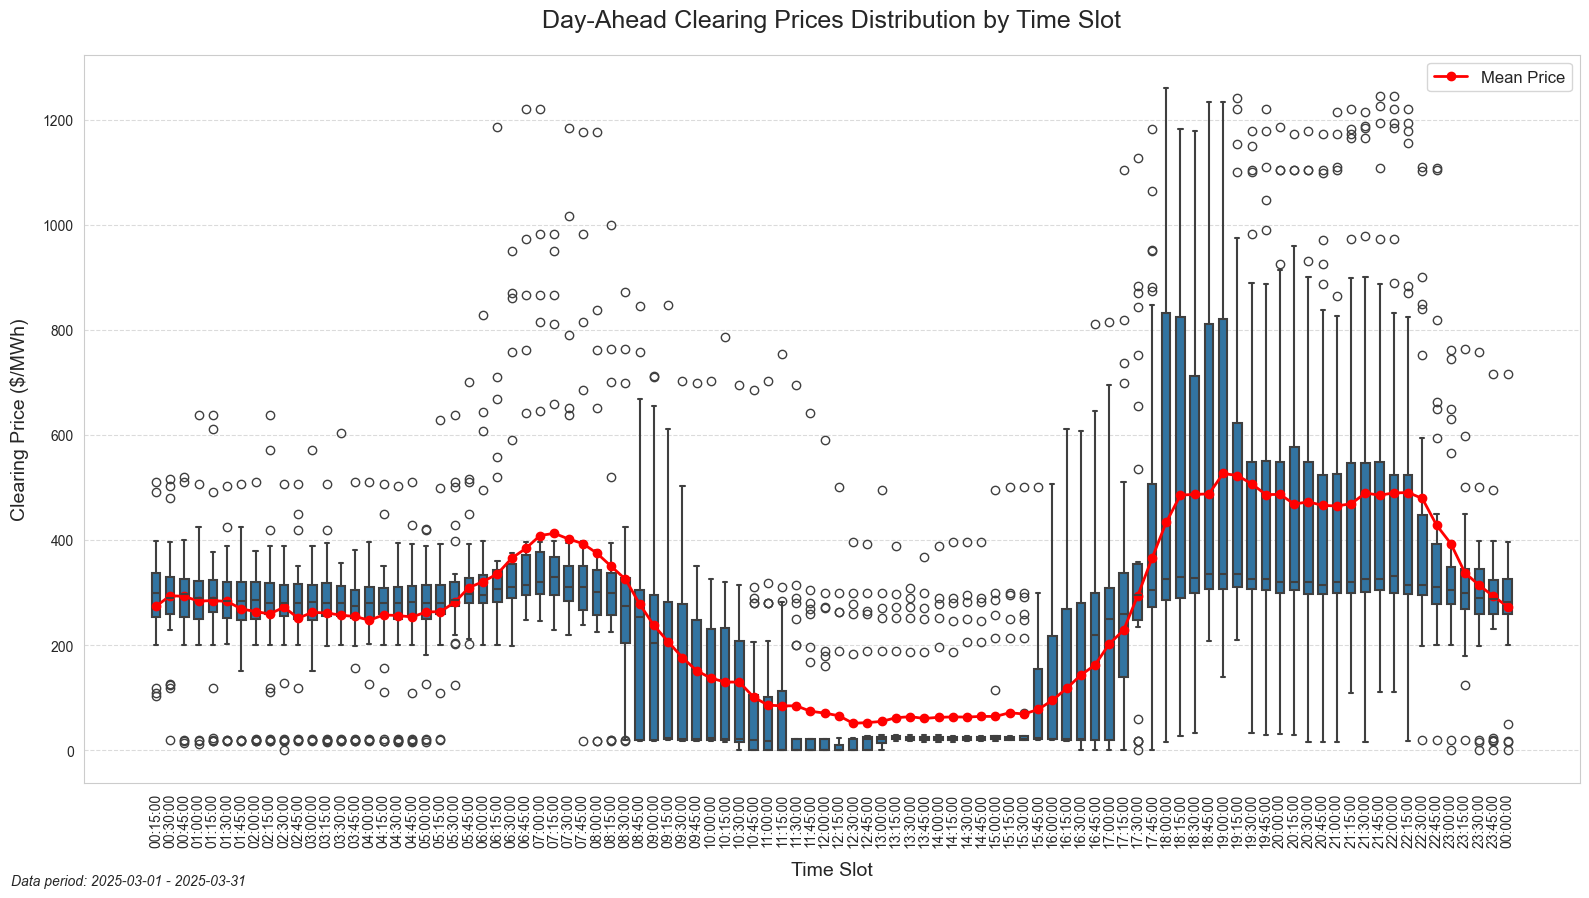

In [35]:
plot_price_boxplot(result_df)

In [36]:
conn.connect().close()